# Computer vision project: Object Detection
    
the goal is to build a face detection model which includes building 
a face detector to locate the position of a face in an image.

Desctiption: 
    
    -> WIDER FACE dataset is a face detection benchmark dataset, of which images are selected from the publicly
    
    available WIDER dataset

    -> we are using 500 images and 1100 faces for ease of computation


Methodology Used: 
    
    Transfer Learning on already trained Mobile Net with UNET architecture

# mount drive: Google Colab is used for computation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#install tensorflow 2.x version

In [19]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 50kB/s 
     |████████████████████████████████| 3.8MB 44.1MB/s 
     |████████████████████████████████| 450kB 52.9MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

# current working directory to project folder

In [1]:
import os
print(os.getcwd()) #current working directory

/content


In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [3]:
print(os.getcwd()) # changed the current working directory to new directory under google drive/colab_notebooks folder

/content/drive/My Drive/Colab Notebooks


In [0]:
project_path="/content/drive/My Drive/Colab Notebooks" 

# LOAD IMAGES.NPY FILE

In [0]:
import numpy as np
data=np.load('/content/drive/My Drive/Colab Notebooks/images.npy',allow_pickle=True)

In [0]:
# SAMPLE DATA

In [6]:
data.shape

(409, 2)

# Checking Sample Images

In [0]:
import matplotlib.pyplot as plt

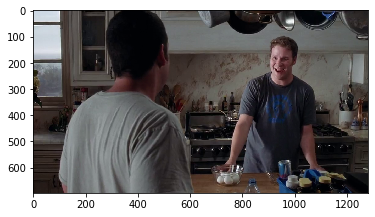

In [13]:
plt.imshow(data[1][0])

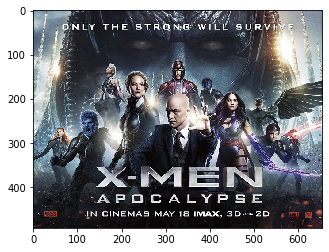

In [8]:
plt.imshow(data[408][0])

# Set Image Dimensions

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

# Features and labels

In [0]:
import cv2

In [0]:
import tensorflow as tf

In [13]:
print(tf.__version__)

2.0.0


In [0]:
from tensorflow.keras.applications.mobilenet import preprocess_input
#When you load a single image, you get the shape of one image, which is (size1,size2,channels).
#In order to create a batch of images, you need an additional dimension: (samples, size1,size2,channels)
#The preprocess_input function is meant to adequate your image to the format the model requires.
#Some models use images with values ranging from 0 to 1. Others from -1 to +1.

In [0]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC) 
# resize to 224X224 ,cv2.INTER_AREA: This is used when we need need to shrink an image.
#cv2.INTER_CUBIC: This is slow but more efficient.
#cv2.INTER_LINEAR: This is primarily used when zooming is required. This is the default interpolation technique in OenCV.
    try:
      img = img[:, :, :3] #all channels
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

# Shape of Xtrain and Mask

In [17]:
X_train.shape

(409, 224, 224, 3)

In [18]:
masks.shape

(409, 224, 224)

# Sample Image Array and Mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


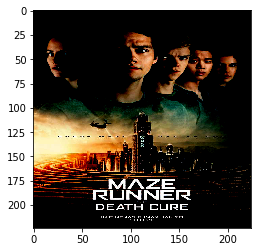

In [19]:
from matplotlib import pyplot
n = 11
pyplot.imshow(X_train[n])

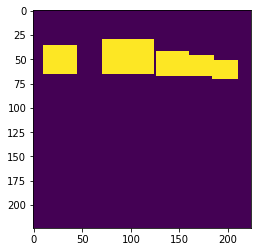

In [20]:
pyplot.imshow(masks[n])

# MODEL

In [0]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 224
WIDTH_CELLS = 224

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

EPOCHS = 1
BATCH_SIZE = 4
PATIENCE = 10

THREADS = 1


In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


In [0]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),include_top=False,alpha=ALPHA, weights='imagenet')  
        
    for layer in model.layers:
        layer.trainable = trainable

    # UPSAMPLING OF LAYERS IN DECODING PART OF UNET ARCHITECTURE 
    # Pointwise convolution layers of mobilenet architecture is selected for Upsampling 
    # and Concatenation is performed between upsampled layers
    
    block1 = model.get_layer("conv_pw_1_relu").output  # has 112x112 dimension
    block2 = model.get_layer("conv_pw_3_relu").output  # has 56x56 dimension
    block3 = model.get_layer("conv_pw_5_relu").output  # has 28x28 dimension
    block4 = model.get_layer("conv_pw_11_relu").output # has 14x14 dimension
    block5 = model.get_layer("conv_pw_13_relu").output # has 7x7 dimension
    

    x = Concatenate()([UpSampling2D()(block5), block4]) #14x14
    x = Concatenate()([UpSampling2D()(x), block3]) #28x28
    x = Concatenate()([UpSampling2D()(x), block2]) #56x56
    x = Concatenate()([UpSampling2D()(x), block1]) #112x112
    x = UpSampling2D()(x) #224x224

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x) 

# create_model function

In [25]:
model = create_model(False)
# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

In [0]:
#save weights

In [0]:
#model.save_weights("Finalmodel.h5")

In [0]:
# Define dice coefficient function

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
#Define Loss function
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
# Compile Model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [0]:
# Define checkpoint and earlystopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min",save_frequency='epoch')
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [33]:
# Fit the model

model.fit(x=X_train,y=masks,epochs=25,verbose=1,callbacks=[checkpoint, reduce_lr, stop],shuffle=True,use_multiprocessing=False)

Train on 409 samples
Epoch 1/25
384/409 [===========================>..] - ETA: 8s - loss: 3.3823 - dice_coefficient: 0.2029 
Epoch 00001: loss improved from inf to 3.36646, saving model to model-3.37.h5
409/409 [==============================] - 138s 337ms/sample - loss: 3.3665 - dice_coefficient: 0.1999
Epoch 2/25
384/409 [===========================>..] - ETA: 7s - loss: 2.8108 - dice_coefficient: 0.1752 
Epoch 00002: loss improved from 3.36646 to 2.81764, saving model to model-2.82.h5
409/409 [==============================] - 125s 306ms/sample - loss: 2.8176 - dice_coefficient: 0.1720
Epoch 3/25
384/409 [===========================>..] - ETA: 7s - loss: 2.5741 - dice_coefficient: 0.1662 
Epoch 00003: loss improved from 2.81764 to 2.57311, saving model to model-2.57.h5
409/409 [==============================] - 125s 305ms/sample - loss: 2.5731 - dice_coefficient: 0.1658
Epoch 4/25
384/409 [===========================>..] - ETA: 7s - loss: 2.3872 - dice_coefficient: 0.1798 
Epoch 00

In [0]:
WEIGHTS_FILE="model-1.04.h5"
THRESHOLD = 0.5
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


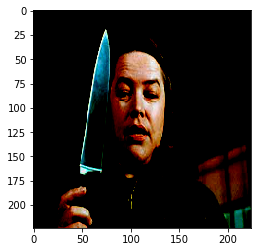

In [44]:
#
n = 26
train_sample = X_train[n]
plt.imshow(train_sample)

# predicted mask for a sample image

In [0]:
image = cv2.resize(train_sample, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.uint8))
region = model.predict(x=np.array([feat_scaled]))[0]
output = np.zeros(train_sample.shape[:2], dtype=np.uint8)

for i in range(region.shape[1]):
   for j in range(region.shape[0]):
      if region[i][j] > THRESHOLD:
         x = int(CELL_WIDTH * j * train_sample.shape[0] / IMAGE_WIDTH)
         y = int(CELL_HEIGHT * i * train_sample.shape[1] / IMAGE_HEIGHT)
         x2 = int(CELL_WIDTH * (j + 1) * train_sample.shape[0] / IMAGE_WIDTH)
         y2 = int(CELL_HEIGHT * (i + 1) * train_sample.shape[1] / IMAGE_HEIGHT)
         output[x:x2,y:y2] = 1

#cv2_imshow("image",sample_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


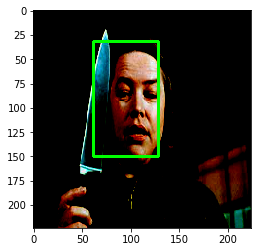

In [46]:
contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    #approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(output)
    cv2.rectangle(train_sample,(x,y),(x + w,y + h),(0,255,0),2)
plt.imshow(train_sample)

# Impose the mask on the image

In [0]:
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

In [0]:
image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

In [0]:
out_image = image2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


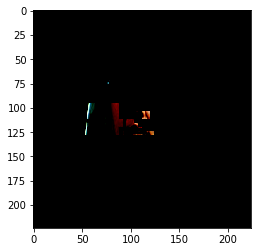

In [50]:
plt.imshow(out_image)

# INFERENCE

-> Transfer Learning enables us to interpret the analysis of Base Model and Transfer the information
to another model of choice based on application on what we need to predict eg: Mobile net as a base 
model for Unet architecture for face detection.

-> Upsampling of Layers is performed after Encoding part of Unet architecture , here mobile net layers performed as Encoders


-> As no of Epochs increased value of dice coefficient increased

-> More no of Epochs and training results in better prediction of region of face and mask

-> The value of No of Epochs and batch size is dependent on CPU AND GPU architecture : eg: Google Colab is used here due to
availability of GPU , TPU and good amount of RAM 